**Model Selection and Training on Train Data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import shap

c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Importing Processed train data**

In [2]:
#importing processed train data
train_data = pd.read_csv('traindata_processed.csv')
pd.set_option('display.max_columns', None)
train_data.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,180388628218,0,612,123247,7,6,10,2,15,1,27,160396,453297,153085,529644,1631,860,3421,881,289573,3586,66,3,4,2024,6,21915
1,455266534868,88,326,210035,58,43,7,1,32,0,360606,160396,24887,153085,529644,1631,860,3421,881,289573,3586,66,10630,14,2024,3,10885
2,1056561957389,809,58352,712507,423,298,10,1,31,1,360606,68652,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,13,2024,4,17575
3,1279900258736,92,32992,774301,2,2,1,0,31,1,360606,13,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,10,2024,16,59976
4,214748368522,148,4359,188041,9,74,6,2,32,0,360606,160396,479,153085,529644,1631,860,3421,881,289573,3586,66,10630,15,2024,1,4087


In [3]:
train_data.shape

(8922805, 27)

**Defining features (X) and target (y)**

In [4]:
X = train_data.drop(columns=['IncidentGrade','Id'])  
y = train_data['IncidentGrade']                 

In [5]:
print(X.dtypes)

OrgId                 int64
IncidentId            int64
AlertId               int64
DetectorId            int64
AlertTitle            int64
Category              int64
EntityType            int64
EvidenceRole          int64
IpAddress             int64
Url                   int64
AccountName           int64
DeviceName            int64
NetworkMessageId      int64
RegistryKey           int64
RegistryValueData     int64
ApplicationName       int64
OAuthApplicationId    int64
FileName              int64
ResourceIdName        int64
OSVersion             int64
City                  int64
Day                   int64
Year                  int64
Hour                  int64
Time                  int64
dtype: object


In [6]:
# Check the range of each column
for col in X.columns:
    print(f"Column: {col}, Min: {X[col].min()}, Max: {X[col].max()}")


Column: OrgId, Min: 0, Max: 6144
Column: IncidentId, Min: 0, Max: 599706
Column: AlertId, Min: 0, Max: 1721456
Column: DetectorId, Min: 0, Max: 9522
Column: AlertTitle, Min: 0, Max: 113174
Column: Category, Min: 0, Max: 19
Column: EntityType, Min: 0, Max: 32
Column: EvidenceRole, Min: 0, Max: 1
Column: IpAddress, Min: 0, Max: 360606
Column: Url, Min: 0, Max: 160396
Column: AccountName, Min: 0, Max: 453297
Column: DeviceName, Min: 0, Max: 153085
Column: NetworkMessageId, Min: 0, Max: 529644
Column: RegistryKey, Min: 0, Max: 1631
Column: RegistryValueData, Min: 0, Max: 860
Column: ApplicationName, Min: 0, Max: 3421
Column: OAuthApplicationId, Min: 0, Max: 881
Column: FileName, Min: 0, Max: 289573
Column: ResourceIdName, Min: 0, Max: 3586
Column: OSVersion, Min: 0, Max: 66
Column: City, Min: 0, Max: 10630
Column: Day, Min: 1, Max: 31
Column: Year, Min: 2023, Max: 2024
Column: Hour, Min: 0, Max: 23
Column: Time, Min: 0, Max: 86399


In [7]:
# Define downcast mapping
downcast_mapping = {
    'int8': ['Category', 'EntityType', 'EvidenceRole', 'OSVersion', 'Day', 'Hour'],
    'int16': ['OrgId', 'DetectorId', 'RegistryKey', 'RegistryValueData', 'ApplicationName', 
              'OAuthApplicationId', 'ResourceIdName', 'City', 'Year'],
    'int32': ['IncidentId', 'AlertId', 'AlertTitle', 'IpAddress', 'Url', 'AccountName', 
              'DeviceName', 'NetworkMessageId', 'FileName', 'Time']
}

# Apply downcasting
for dtype, cols in downcast_mapping.items():
    for col in cols:
        X[col] = X[col].astype(dtype)

print(X.dtypes)  # Verify updated datatypes


OrgId                 int16
IncidentId            int32
AlertId               int32
DetectorId            int16
AlertTitle            int32
Category               int8
EntityType             int8
EvidenceRole           int8
IpAddress             int32
Url                   int32
AccountName           int32
DeviceName            int32
NetworkMessageId      int32
RegistryKey           int16
RegistryValueData     int16
ApplicationName       int16
OAuthApplicationId    int16
FileName              int32
ResourceIdName        int16
OSVersion              int8
City                  int16
Day                    int8
Year                  int16
Hour                   int8
Time                  int32
dtype: object


In [8]:
# Stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [9]:
# Checking class distribution in training and validation sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Validation set class distribution:\n", y_val.value_counts(normalize=True))

Training set class distribution:
 IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64
Validation set class distribution:
 IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64


**Model Selection and Training:**

Baseline Models


In [10]:
# Baseline Models
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Training and evaluation on validation set
for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n", classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


Training Logistic Regression...
Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Class 0       0.58      0.45      0.51   1148340
     Class 1       0.35      0.33      0.34    586464
     Class 2       0.51      0.68      0.58    942038

    accuracy                           0.50   2676842
   macro avg       0.48      0.48      0.48   2676842
weighted avg       0.51      0.50      0.50   2676842


Training Decision Tree...
Decision Tree Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00   1148340
     Class 1       0.99      0.99      0.99    586464
     Class 2       1.00      1.00      1.00    942038

    accuracy                           1.00   2676842
   macro avg       1.00      1.00      1.00   2676842
weighted avg       1.00      1.00      1.00   2676842



Advanced Models

In [11]:
X = train_data.drop(columns=['IncidentGrade','Id'])  
y = train_data['IncidentGrade']  
# Stratified train-validation split
X_train_sample, X_val, y_train_sample, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

# Random Forest Model
random_forest_model = RandomForestClassifier(
    n_estimators=30,        # Reduce the number of trees
    max_depth=10,           # Limit tree depth
    max_features='sqrt',    # Use square root of total features
    class_weight='balanced',
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

# Train and Evaluate Random Forest
print("\nTraining Random Forest...")
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_val)
print("Random Forest Classification Report:\n", classification_report(y_val, y_pred_rf, target_names=['Class 0', 'Class 1', 'Class 2']))

# LightGBM Model
lightgbm_model = LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    device='gpu',           # Use GPU
    n_estimators=50,        # Reduce the number of boosting rounds
    max_depth=10,           # Limit the maximum depth of trees
    feature_fraction=0.8    # Use only 80% of features in each iteration
)

# Train and Evaluate LightGBM
print("\nTraining LightGBM...")
lightgbm_model.fit(X_train, y_train)
y_pred_lgbm = lightgbm_model.predict(X_val)
print("LightGBM Classification Report:\n", classification_report(y_val, y_pred_lgbm, target_names=['Class 0', 'Class 1', 'Class 2']))



Training Random Forest...
Random Forest Classification Report:
               precision    recall  f1-score   support

     Class 0       0.74      0.94      0.83   1148340
     Class 1       0.81      0.73      0.77    586464
     Class 2       0.97      0.73      0.83    942038

    accuracy                           0.82   2676842
   macro avg       0.84      0.80      0.81   2676842
weighted avg       0.84      0.82      0.82   2676842


Training LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3644
[LightGBM] [Info] Number of data points in the train set: 6245963, number of used features: 25
[LightGBM] [Info] Using GPU Device: gfx90c, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling Op

In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Set initial parameters for XGBoost with class weights
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': len(set(y_train)),
    'tree_method': 'hist',
    'device': 'cuda',
    'learning_rate': 0.005,  # Reduced learning rate for more gradual convergence
    'max_depth': 13,  # Increased max_depth
    'eval_metric': 'mlogloss',  # Log loss metric for multi-class classification
    'scale_pos_weight': class_weight_dict,  # Adding class weights
    'subsample': 0.85,  # Randomly sample 85% of data to train each tree
    'colsample_bytree': 0.85,  # Randomly sample 85% of features for each tree
    'n_estimators': 500  # Increased number of boosting rounds
}

# Train the model with early stopping and display loss every 50 rounds
model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=500,  # Increased rounds for better convergence
    evals=[(dtrain, 'train'), (dval, 'eval')], 
    early_stopping_rounds=50, 
    verbose_eval=50  # Display loss every 50 rounds
)

# Convert X_val to DMatrix for prediction
dval_pred = xgb.DMatrix(X_val)

# Generate predictions
y_pred = model.predict(dval_pred)

# Generate the classification report
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))


c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators", "scale_pos_weight" } ar

[0]	train-mlogloss:1.09376	eval-mlogloss:1.09376
[50]	train-mlogloss:0.89049	eval-mlogloss:0.89044
[100]	train-mlogloss:0.74753	eval-mlogloss:0.74748
[150]	train-mlogloss:0.64189	eval-mlogloss:0.64182
[200]	train-mlogloss:0.56168	eval-mlogloss:0.56160
[250]	train-mlogloss:0.49759	eval-mlogloss:0.49753
[300]	train-mlogloss:0.44605	eval-mlogloss:0.44602
[350]	train-mlogloss:0.40519	eval-mlogloss:0.40519
[400]	train-mlogloss:0.37207	eval-mlogloss:0.37211
[450]	train-mlogloss:0.34459	eval-mlogloss:0.34467
[499]	train-mlogloss:0.32306	eval-mlogloss:0.32317
XGBoost Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.98      0.91   1148340
     Class 1       0.96      0.80      0.87    586464
     Class 2       0.97      0.88      0.92    942038

    accuracy                           0.90   2676842
   macro avg       0.92      0.89      0.90   2676842
weighted avg       0.91      0.90      0.90   2676842



**Taking Only 10% of the training data for computational efficeincy**

In [14]:
# Sample 10% of the training data
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [15]:
# Check the sizes
print("Original Training Data Size:", X_train.shape)
print("Sampled Training Data Size:", X_train_sample.shape)

Original Training Data Size: (6245963, 25)
Sampled Training Data Size: (624596, 25)


**SMOTE**


In [16]:
# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_sample, y_train_sample)

In [17]:
# Checking the new class distribution
print("Original class distribution:\n", y_train_sample.value_counts())
print("After SMOTE class distribution:\n", y_train_smote.value_counts())

Original class distribution:
 IncidentGrade
0    267143
2    220149
1    137304
Name: count, dtype: int64
After SMOTE class distribution:
 IncidentGrade
2    267143
0    267143
1    267143
Name: count, dtype: int64


Training XGB model on class balanced data


In [18]:
# Training the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')      
xgb.fit(X_train_smote, y_train_smote)

# Prediction on the validation set
y_val_pred = xgb.predict(X_val)

# Evaluate performance
print("Validation Set Classification Report (After SMOTE):")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Validation Set Classification Report (After SMOTE):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92   1148340
     Class 1       0.84      0.90      0.87    586464
     Class 2       0.95      0.90      0.93    942038

    accuracy                           0.91   2676842
   macro avg       0.90      0.91      0.91   2676842
weighted avg       0.91      0.91      0.91   2676842



SHAP Analysis for Feature Importance


In [19]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val)

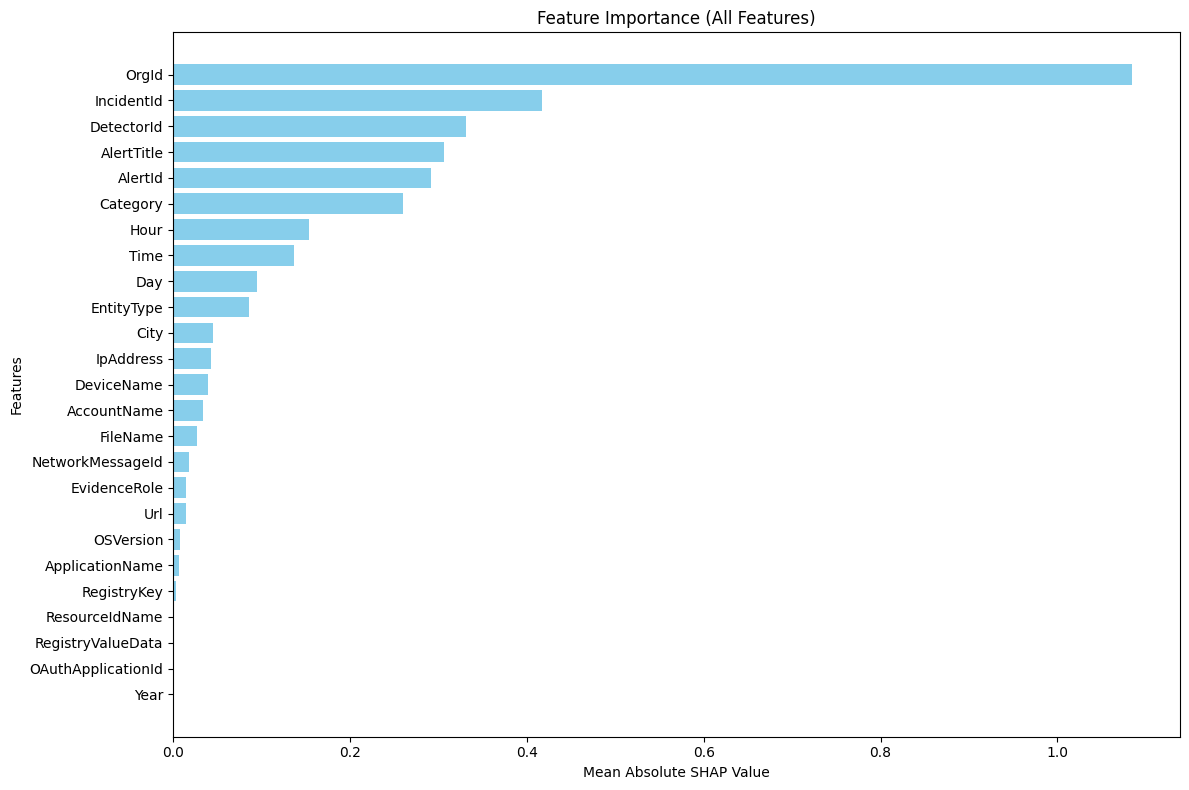

In [20]:
import numpy as np

# If shap_values has a 3rd dimension for classes, we need to reduce it to a 2D array (samples x features)
mean_shap_values = np.abs(shap_values).mean(axis=(0, 2))  # Mean across samples and classes

# Create a DataFrame for sorting and visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': mean_shap_values
}).sort_values(by='Importance', ascending=False)

# Plot a bar chart for all features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Most important features at the top
plt.title('Feature Importance (All Features)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [21]:
# Defining top 13 features based on SHAP
top_13_features = ['OrgId', 'IncidentId', 'DetectorId', 'Category', 'AlertId','AlertTitle', 
                    'Day', 'EntityType', 'DeviceName', 'City', 'AccountName', 'IpAddress', 'Time']

In [22]:
# Filter datasets for top 13 features
X_train_top13 = X_train_smote[top_13_features]
X_val_top13 = X_val[top_13_features]

In [23]:
# Verify shapes
print("Shape of training set with top features:", X_train_top13.shape)
print("Shape of validation set with top features:", X_val_top13.shape)

Shape of training set with top features: (801429, 13)
Shape of validation set with top features: (2676842, 13)


**Training XGB with only top 13 features**

In [24]:
# Train the XGBoost model with top features
xgb_top13 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top13.fit(X_train_top13, y_train_smote)

# Predict on the validation set
y_val_pred_top13 = xgb_top13.predict(X_val_top13)

# Evaluate performance

print("Validation Set Classification Report (Top 13 Features):")
print(classification_report(y_val, y_val_pred_top13, target_names=['Class 0', 'Class 1', 'Class 2']))

c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Validation Set Classification Report (Top 13 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92   1148340
     Class 1       0.84      0.91      0.87    586464
     Class 2       0.95      0.91      0.93    942038

    accuracy                           0.91   2676842
   macro avg       0.91      0.91      0.91   2676842
weighted avg       0.92      0.91      0.91   2676842



**Hyperparameter Tuning**

In [25]:
# Define hyperparameter grid
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # To address class imbalance further
}

# Randomized search with GPU support
random_search_top13 = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        tree_method='hist',  # Enable GPU support
        device='cuda'  # Use GPU for predictions
    ),
    param_distributions=param_distributions,
    scoring='f1_macro',  # Scoring metric
    cv=3,
    n_iter=20,  # Number of random combinations
    verbose=1,
    n_jobs=-1  # Parallel processing
)

# Perform hyperparameter tuning
random_search_top13.fit(X_train_top13, y_train_smote)

# Get the best model
best_xgb_top13 = random_search_top13.best_estimator_
print("Best Parameters:", random_search_top13.best_params_)

# Evaluate on validation set
y_val_pred_best_top13 = best_xgb_top13.predict(X_val_top13)
print("Validation Set Classification Report (Tuned Top 13 Features):")
print(classification_report(y_val, y_val_pred_best_top13, target_names=['Class 0', 'Class 1', 'Class 2']))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  w

Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Validation Set Classification Report (Tuned Top 13 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92   1148340
     Class 1       0.84      0.91      0.87    586464
     Class 2       0.96      0.91      0.93    942038

    accuracy                           0.91   2676842
   macro avg       0.91      0.91      0.91   2676842
weighted avg       0.92      0.91      0.92   2676842



The hyperparameter tuned model gives best scores. Saving the model.


In [26]:
import joblib

# Save the model
joblib.dump(best_xgb_top13, 'best_xgboost_Classification_model_SMOTE.pkl')
print("Model saved as best_xgboost_Classification_model_SMOTE.pkl")

Model saved as best_xgboost_Classification_model_SMOTE.pkl


**EVALUATION ON TEST SET**

In [27]:
# Loading test data
test_data = pd.read_csv('testdata_processed.csv')
test_data.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueData,ApplicationName,OAuthApplicationId,FileName,ResourceIdName,OSVersion,City,Day,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,11,0,28,0,360606,160396,863,153085,529644,1631,860,3421,881,289573,3586,66,10630,4,2024,22,82520
1,1400159342154,3,91158,632273,2,2,1,0,15,0,360606,160396,453297,2833,529644,1631,860,3421,881,289573,3586,0,10630,3,2024,12,46649
2,1279900255923,145,32247,131719,2932,10807,11,0,23,1,360606,160396,453297,153085,529644,1631,860,3421,881,14,3586,66,10630,8,2024,3,12037
3,60129547292,222,15294,917686,0,0,10,1,7,1,360606,160396,453297,153085,529644,1631,860,3421,881,289573,3586,66,10630,12,2024,12,43594
4,515396080539,363,7615,5944,27,18,5,0,28,0,360606,160396,136104,153085,529644,1631,860,3421,881,289573,3586,66,10630,6,2024,17,63665


In [28]:
# Selecting only top 13 features and setting features and target
X_test_top13 = test_data[top_13_features] 
y_test = test_data['IncidentGrade']

In [29]:
# Predicting on the test set using the best model
y_test_pred_top13 = best_xgb_top13.predict(X_test_top13)

# Evaluate performance on test data
print("Test Set Classification Report (Top 13 Features):")
print(classification_report(y_test, y_test_pred_top13, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 13 Features):
              precision    recall  f1-score   support

     Class 0       0.92      0.81      0.86   1752895
     Class 1       0.69      0.91      0.78    902664
     Class 2       0.94      0.88      0.91   1492329

    accuracy                           0.86   4147888
   macro avg       0.85      0.87      0.85   4147888
weighted avg       0.88      0.86      0.86   4147888



**Without Using Smote**

In [30]:
# Train the XGBoost model
xgb = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb.fit(X_train_sample, y_train_sample)

# Predict on the validation set
y_val_pred = xgb.predict(X_val)

# Evaluate performance
print("Validation Set Classification Report without smote:")
print(classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Validation Set Classification Report without smote:
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.93   1148340
     Class 1       0.93      0.85      0.89    586464
     Class 2       0.95      0.91      0.93    942038

    accuracy                           0.92   2676842
   macro avg       0.93      0.91      0.92   2676842
weighted avg       0.92      0.92      0.92   2676842



In [31]:
# Define top 13 features based on SHAP
top_13_features = ['OrgId', 'IncidentId', 'DetectorId', 'Category', 'AlertId','AlertTitle', 
                    'Day', 'EntityType', 'DeviceName', 'City', 'AccountName', 'IpAddress', 'Time']
# Filter datasets for top 13 features
X_train_sample_top13 = X_train_sample[top_13_features]
X_val_top13 = X_val[top_13_features]

# Verify shapes
print("Shape of training set with top features:", X_train_sample_top13.shape)
print("Shape of validation set with top features:", X_val_top13.shape)

Shape of training set with top features: (624596, 13)
Shape of validation set with top features: (2676842, 13)


**Training XGB with only top 13 features on original dataset**

In [32]:
# Train the XGBoost model with top features
xgb_top13 = XGBClassifier(random_state=42,tree_method='hist',device='cuda')
xgb_top13.fit(X_train_sample_top13, y_train_sample)

# Predict on the validation set
y_val_pred_top13 = xgb_top13.predict(X_val_top13)

# Evaluate performance

print("Validation Set Classification Report (Top 13 Features):")
print(classification_report(y_val, y_val_pred_top13, target_names=['Class 0', 'Class 1', 'Class 2']))

c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Validation Set Classification Report (Top 13 Features):
              precision    recall  f1-score   support

     Class 0       0.90      0.96      0.93   1148340
     Class 1       0.93      0.86      0.89    586464
     Class 2       0.95      0.92      0.93    942038

    accuracy                           0.92   2676842
   macro avg       0.93      0.91      0.92   2676842
weighted avg       0.92      0.92      0.92   2676842



Hyperparameter Tuning

In [33]:
# Define hyperparameter grid
param_distributions = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.001, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]  # To address class imbalance further
}

# Randomized search
random_search_top13 = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42,
                            tree_method='hist',  # Enable GPU support
                            device='cuda'  # Use GPU for predictions
                           ),
    param_distributions=param_distributions,
    scoring='f1_macro',
    cv=3,
    n_iter=50,  # Number of random combinations
    verbose=1,
    n_jobs=-1
)

# Perform hyperparameter tuning
random_search_top13.fit(X_train_sample_top13, y_train_sample)
# Get the best model
best_xgb_top13 = random_search_top13.best_estimator_
print("Best Parameters:", random_search_top13.best_params_)

# Evaluate on validation set
y_val_pred_best_top13 = best_xgb_top13.predict(X_val_top13)
print("Validation Set Classification Report (Tuned Top 13 Features):")
print(classification_report(y_val, y_val_pred_best_top13, target_names=['Class 0', 'Class 1', 'Class 2']))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  w

Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Validation Set Classification Report (Tuned Top 13 Features):
              precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96   1148340
     Class 1       0.95      0.92      0.93    586464
     Class 2       0.97      0.95      0.96    942038

    accuracy                           0.95   2676842
   macro avg       0.95      0.95      0.95   2676842
weighted avg       0.95      0.95      0.95   2676842



In [34]:
import joblib

# Save the model
joblib.dump(best_xgb_top13, 'best_XGB_Classification_model_without_SMOTE.pkl')
print("Model saved as best_XGB_Classification_model_without_SMOTE.pkl")

Model saved as best_XGB_Classification_model_without_SMOTE.pkl


**Final Evaluation on Test Set**

In [35]:
# Predict on the test set
y_test_pred_top13 = best_xgb_top13.predict(X_test_top13)

# Evaluate performance on test data
print("Test Set Classification Report (Top 13 Features):")
print(classification_report(y_test, y_test_pred_top13, target_names=['Class 0', 'Class 1', 'Class 2']))

Test Set Classification Report (Top 13 Features):
              precision    recall  f1-score   support

     Class 0       0.91      0.93      0.92   1752895
     Class 1       0.89      0.86      0.87    902664
     Class 2       0.93      0.93      0.93   1492329

    accuracy                           0.91   4147888
   macro avg       0.91      0.90      0.91   4147888
weighted avg       0.91      0.91      0.91   4147888

